# LSTM Time series (Keras/Tensorflow)

In [1]:
import IPython.display
import pandas as pd

from LSTM import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

figures saved to ../Figures/Modeling/LSTM


## Data exploration

In [2]:
# Load data
VM = load_VM('917.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]

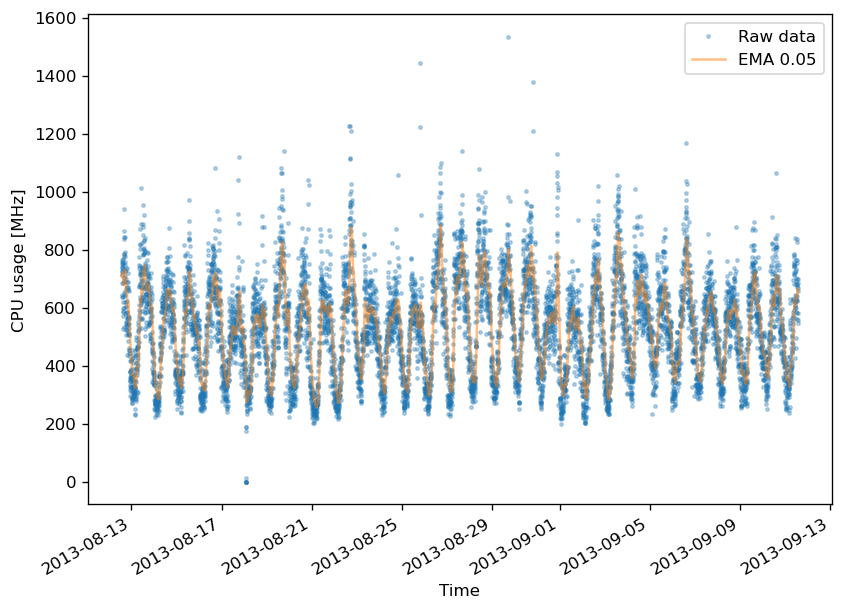

In [3]:
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

Metal device set to: Apple M1


2022-02-28 20:13:45.170599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-28 20:13:45.170715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


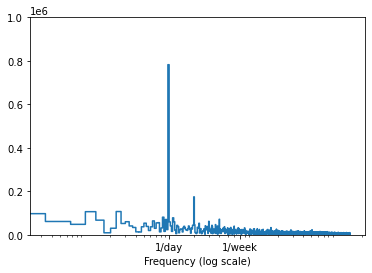

In [4]:
%matplotlib inline
fft = tf.signal.rfft(df['CPU usage [MHZ]'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(VM)
timestamps_per_day = 60*24/5
days_per_dataset = n_samples_h/ (timestamps_per_day)

f_per_day = f_per_dataset/days_per_dataset
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1000000)
# plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7], labels=['1/day', '1/week'])
_ = plt.xlabel('Frequency (log scale)')

In [5]:
df = add_daily_info(df)

/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))


Text(0.5, 1.0, 'Time of day signal')

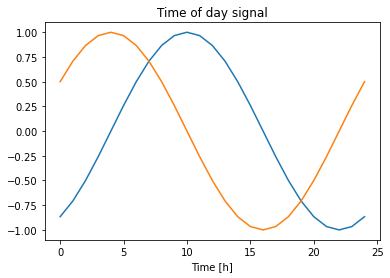

In [6]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## Split the data

In [7]:
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

## Normalizing the data

In [8]:
scaler = MinMaxScaler()
train_df, val_df, test_df = data_transformation(scaler, train_df, val_df, test_df)

/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, train_df.columns] = scaler.fit_transform(train_df)
/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:, val_df.columns] = scaler.transform(val_df)
/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:175: Se

## Data windowing

In [9]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['CPU usage [MHZ]'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['CPU usage [MHZ]']

In [10]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)


2022-02-28 15:40:04.384214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [51]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['CPU usage [MHZ]'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['CPU usage [MHZ]']

In [64]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['CPU usage [MHZ]'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['CPU usage [MHZ]']

## Baseline

In [11]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
          return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [12]:
baseline = Baseline(label_index=single_step_window.column_indices['CPU usage [MHZ]'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

34/54 [=================>............] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0377

2022-02-28 15:40:10.308775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0375


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

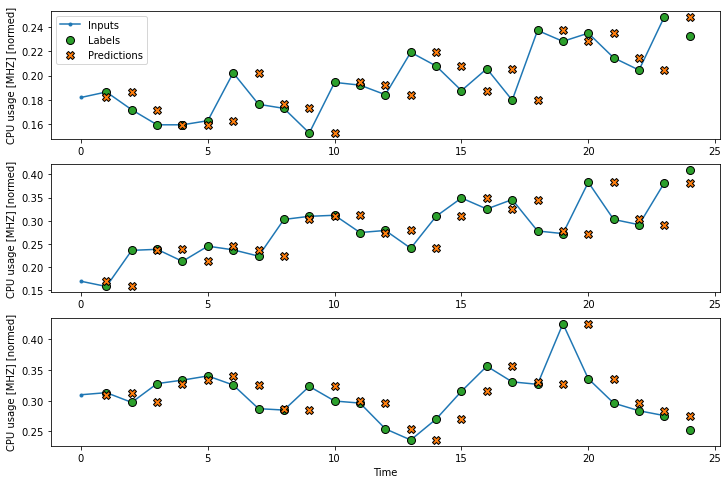

In [50]:
wide_window.plot(baseline)

In [13]:
# Prediction
pred = baseline.predict(single_step_window.test_pred)
pred = np.reshape(pred,(862, -1))
# Convert to dataframe
pred_df = pd.DataFrame(pred, columns=['CPU usage [MHZ]'])
pred_df.index = single_step_window.test_df.index
# Inverse transform
# pred_df['Day sin'] = test_df['Day sin']
# pred_df['Day cos'] = test_df['Day cos']
pred_trf = scaler.inverse_transform(pred_df)
pred_df_trf = pd.DataFrame(data=pred_trf, columns=test_df.columns, index=test_df.index)

2022-02-28 15:40:16.435342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


ValueError: non-broadcastable output operand with shape (862,1) doesn't match the broadcast shape (862,3)

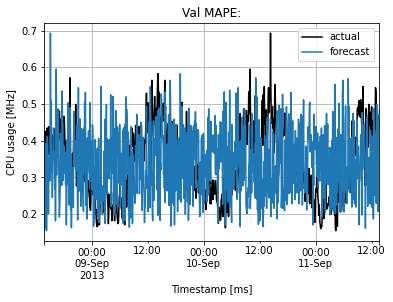

In [14]:
# Figure
%matplotlib inline
# test_trf = scaler.inverse_transform(test_df)
# test_df_trf = pd.DataFrame(data=test_trf, columns=test_df.columns, index=test_df.index)
fig = plt.figure()
plt.grid()
test_df['CPU usage [MHZ]'].plot(label='actual', color='k')
pred_df['CPU usage [MHZ]'].plot(label='forecast')
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAPE:')
plt.grid()
plt.legend()
plt.show()

In [10]:
wide_window = WindowGenerator(
    input_width=20, label_width=1, shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['CPU usage [MHZ]'])

wide_window

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Label column name(s): ['CPU usage [MHZ]']

In [12]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 3)
Output shape: (32, 1, 1)


In [ ]:
wide_window.plot(baseline)

## LSTM

In [12]:
lstm_model = LstmModel(input_width=20,
                      label_width=1,
                      df=df,
                      train_df=train_df,
                      val_df=val_df,
                      test_df=test_df,
                      epoch=40,
                      units=20,
                      layers=1,
                      dropout=0,
                      )

In [10]:
# Magic func to use TensorBoard directly in IPython
%load_ext tensorboard

In [11]:
log_dir = f'logs/fit/{lstm_model.name}'
%tensorboard --logdir=logdir

Launching TensorBoard...

In [12]:
IPython.display.clear_output()
lstm_model.compile_and_fit()

Training:


2022-02-25 17:26:34.776841: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 20)                  1920      
                                                                 
 dense (Dense)               (32, 1)                   21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-02-25 17:26:35.382641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-25 17:26:35.559281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-25 17:26:35.994229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_percentage_error: 172516.2031 - mean_absolute_error: 0.0526

2022-02-25 17:26:47.719838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-25 17:26:47.772209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 15s 73ms/step - loss: 0.0053 - mean_absolute_percentage_error: 172516.2031 - mean_absolute_error: 0.0526 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 10.9236 - val_mean_absolute_error: 0.0372
Epoch 2/40
180/180 [==============================] - 11s 62ms/step - loss: 0.0030 - mean_absolute_percentage_error: 108611.3047 - mean_absolute_error: 0.0398 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 10.6475 - val_mean_absolute_error: 0.0366
Epoch 3/40
180/180 [==============================] - 11s 63ms/step - loss: 0.0028 - mean_absolute_percentage_error: 100050.8281 - mean_absolute_error: 0.0385 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 11.4966 - val_mean_absolute_error: 0.0381
Epoch 4/40
180/180 [==============================] - 11s 61ms/step - loss: 0.0028 - mean_absolute_percentage_error: 90527.2891 - mean_absolute_error: 0.0383 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 10.3473 - val_mean_abs

Inference:
45/45 [==============================] - 1s 32ms/step - loss: 0.0021 - mean_absolute_percentage_error: 10.4066 - mean_absolute_error: 0.0351


ValueError: Format '03508371859788895]' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

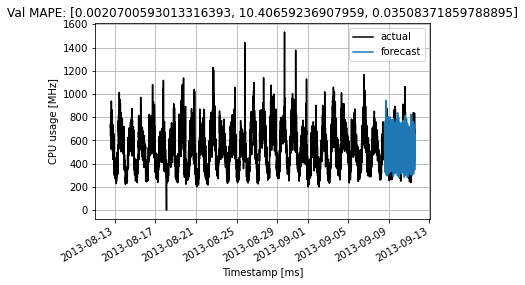

In [14]:
IPython.display.clear_output()
pred = lstm_model.prediction(scaler)

In [15]:
performance_val, performance_test = lstm_model.evaluation(pred,scaler)

NameError: name 'pred' is not defined

In [ ]:
# Figure
fig = plt.figure()
plt.grid()
df['CPU usage [MHZ]'].plot(label='actual', color='k')
pred['CPU usage [MHZ]'].plot(label='forecast')
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAPE: {val_mape}')
plt.grid()
plt.legend()
if not os.access(os.path.join(FIGURES_PATH, self.name), os.F_OK):
    os.mkdir(os.path.join(FIGURES_PATH, self.name))
save_path = os.path.join(FIGURES_PATH, self.name, 'forecast')
plt.savefig(save_path, bbox_inches='tight')
plt.close(fig)

## LSTM

In [ ]:
wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['CPU usage [MHZ]'])

wide_window

In [ ]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [14]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    # Shape => [batch, time, features]
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

In [26]:
print('Input shape:', wide_window.example[0].shape)
print('Label shape:', wide_window.example[1].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (128, 30, 3)
Label shape: (128, 1, 1)
Output shape: (128, 30, 1)


In [16]:
wide_window.train.element_spec

(TensorSpec(shape=(None, 30, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 30, 3)
Labels shape (batch, time, features): (128, 1, 1)


In [16]:
wide_window

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Label column name(s): ['CPU usage [MHZ]']

In [18]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (128, 30, 50)             10800     
                                                                 
 dense_1 (Dense)             (128, 30, 1)              51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=20,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [21]:
val_performance = {}
performance = {}

In [22]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

14/14 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_absolute_error: 0.0550


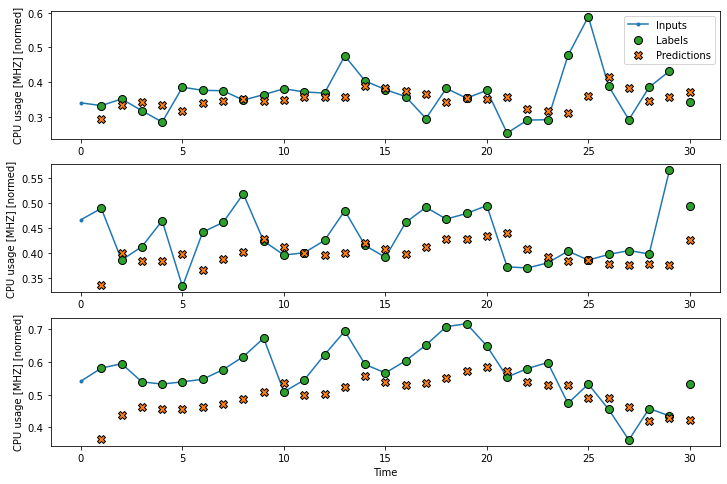

In [28]:
wide_window.plot(lstm_model)

In [29]:
pred = lstm_model.predict(wide_window.test_pred, batch_size = 128)

2022-02-28 21:05:08.422436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 21:05:08.492542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


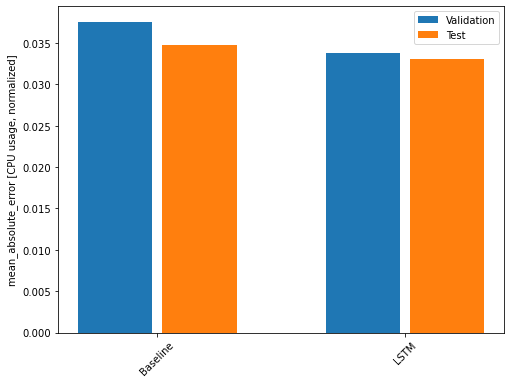

In [95]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [CPU usage, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

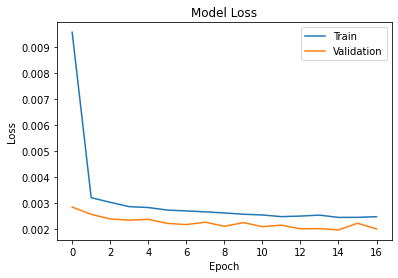

In [19]:
# Loss History
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [30]:
IPython.display.clear_output()
pred = lstm_model.predict(wide_window.test_pred, batch_size=128, verbose=True)

7/7 [==============================] - 0s 11ms/step


In [32]:
pred = pred[:,0,:]

In [33]:
pred_df = pd.DataFrame(pred, columns=['CPU usage [MHZ]'])
pred_df.index = test_df.index
pred_df['Day sin'] = test_df['Day sin']
pred_df['Day cos'] = test_df['Day cos']

In [34]:
pred_trf = scaler.inverse_transform(pred_df)
pred_df_trf = pd.DataFrame(data=pred_trf, columns=test_df.columns, index=test_df.index)

In [35]:
%matplotlib tk
test_trf = scaler.inverse_transform(test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=test_df.columns, index=test_df.index)
plt.figure()
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k')
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast')
plt.ylabel('CPU usage [MHz]')
plt.grid()
plt.legend()

In [33]:
test_trf = scaler.inverse_transform(test_df)
aux =test_trf[:,0]

In [16]:
wide_window.train.shape()

AttributeError: 'MapDataset' object has no attribute 'shape'

In [36]:
wide_window.example[0].shape

TensorShape([32, 20, 3])

In [37]:
lstm_model.window.example[0].shape

TensorShape([32, 20, 3])

In [34]:
lstm_model.model.build(lstm_model.window.example[0].shape)

In [35]:
lstm_model.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (32, 20)                  1920      
                                                                 
 dense_2 (Dense)             (32, 1)                   21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


In [46]:
lstm_model.window.test.element_spec

(TensorSpec(shape=(None, 20, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

## Multi LSTM

In [ ]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)